# California fire zone analysis

By [Ben Welsh](https://palewi.re/who-is-ben-welsh/)

The Los Angeles Times conducted an analysis of California buildings within fire hazard zones for the Dec. 18, 2018, story ["A million California buildings face wildfire risk. ‘Extraordinary steps’ are needed to protect them."](https://www.latimes.com/projects/la-me-california-buildings-in-fire-zones/)

It found that at least 1.1 million structures, roughly 1 in 10 in the state, are within the highest risk zones. Here's how we did it.

### Configuration

Set shared variables that will be used by all the notebooks in this repository.

In [2]:
import os
import pandas as pd
import altair as alt

In [56]:
base_dir = os.getcwd()

In [4]:
input_dir = os.path.join(base_dir, 'input')
output_dir = os.path.join(base_dir, 'output')

In [5]:
%%capture
%store input_dir
%store output_dir

### Download building footprints

Retrieve California building footprints mapped by Microsoft by running [download-buildings.ipynb](src/download-buildings.ipynb). Microsoft's list was compiled by a computer program that scours aerial and satellite photos. While it is among the most complete lists available, it is not comprehensive. According to a Microsoft expert who helped create the list, the database is believed to a slight undercount of the state's buildings.

In [5]:
%%capture
%run src/download-buildings.ipynb 

### Tidy buildings

Convert the Microsoft building footprints into centroid points by running [tidy-buildings.ipynb](src/tidy-buildings.ipynb).

In [6]:
%%capture
%run src/tidy-buildings.ipynb 

### Split buildings

Break the building points into batches for processing by running [split-buildings.ipynb](src/split-buildings.ipynb).

In [7]:
%%capture
%run src/split-buildings.ipynb 

### Merge fire zones

Join the buildings to "very severe" fire zones by running [merge-fire-zones.ipynb](src/merge-fire-zones.ipynb). The maps were drawn by scientists at the California Department of Forestry and Fire Protection in 2007 using a computerized model that considers terrain, vegetation and the location of past fires. Our methodology was vetted by an expert there.

In [1]:
%%capture
%run src/merge-fire-zones.ipynb 

### Merge neighborhoods

Join the buildings to neighborhoods defined by The Times' [Mapping L.A.](http://maps.latimes.com) project by running [merge-neighborhoods.ipynb](src/merge-neighborhoods.ipynb).

In [10]:
%%capture
%run src/merge-neighborhoods.ipynb 

### Combine merges

Join all of the merges conducted above into a single file for analysis by running [combine-merges.ipynb](src/combine-merges.ipynb).

In [11]:
%%capture
%run src/combine-merges.ipynb 

### Run the analysis

First some configuration

In [6]:
intcomma = lambda x: print(f"{x:,.0f}")

In [7]:
percent = lambda numerator, denominator: print(f"{(numerator/denominator)*100:.1f}%")

Read in the prepared data.

In [8]:
points = pd.read_csv(os.path.join(output_dir, "buildings-points-with-analysis.csv"))

How many buildings are in the state?

In [9]:
intcomma(len(points))

10,988,525


How many buildings are in a "very severe" hazard zone?

In [10]:
points['in_firezone'] = ~pd.isnull(points.fire_zone_type)

In [11]:
in_firezone = points[points.in_firezone]

In [12]:
intcomma(len(in_firezone))

1,151,181


What percentage is that?

In [13]:
percent(len(in_firezone), len(points))

10.5%


What type of fire zone has more buildings?

In [14]:
zonetype_counts = in_firezone.fire_zone_type.value_counts().reset_index()

In [15]:
zonetype_counts.columns = ["zonetype", "building_count"]

In [16]:
zonetype_counts['percent'] = zonetype_counts.building_count / zonetype_counts.building_count.sum()

In [17]:
zonetype_counts

,zonetype,building_count,percent
0,LRA,669311,0.581412
1,SRA,481870,0.418588


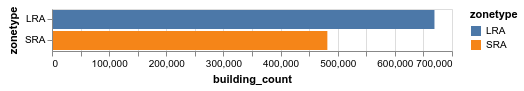

In [18]:
alt.Chart(zonetype_counts).mark_bar().encode(
    x="building_count:Q",
    y="zonetype:N",
    color="zonetype:N"
)

What Census defined places have the most buildings in fires zones?

In [40]:
def crosstab_boolean(df, by_field, bool_field):
    """
    Generate a crosstab that analyzes a boolean field.
    """
    # Group on the index field and count frequencies of the boolean field. 
    counts = df.groupby([
        by_field,
        bool_field
    ]).size().rename("building_count").reset_index()
    
    # Flip the result into a crosstab
    pivot = counts.pivot(
        index=by_field,
        columns=bool_field,
        values="building_count"
    ).fillna(0).reset_index()
    
    # Calculate total
    pivot['total'] = pivot[True] + pivot[False]
    
    # Calculate percentages
    pivot[f'{bool_field}_percent'] = round((pivot[True] / pivot['total'])*100, 2)

    # Clean up the column names
    cleaned = pivot.rename(columns={
        False: f"not_{bool_field}",
        True: bool_field
    })
    
    # Return the result
    return cleaned.set_index(by_field)

In [41]:
place_pivot = crosstab_boolean(points, "place_name", "in_firezone")

In [42]:
top_places = place_pivot.sort_values("in_firezone", ascending=False).head(20)

In [43]:
top_places

in_firezone,not_in_firezone,in_firezone,total,in_firezone_percent
place_name,,,,
Los Angeles city,666442.0,114355.0,780797.0,14.65
San Diego city,224153.0,88724.0,312877.0,28.36
Santa Clarita city,33712.0,18206.0,51918.0,35.07
Thousand Oaks city,20899.0,17062.0,37961.0,44.95
Rancho Palos Verdes city,356.0,13519.0,13875.0,97.43
Oakland city,74663.0,12186.0,86849.0,14.03
Glendale city,27580.0,11870.0,39450.0,30.09
Paradise town,149.0,11703.0,11852.0,98.74
Big Bear City CDP,1229.0,10908.0,12137.0,89.87


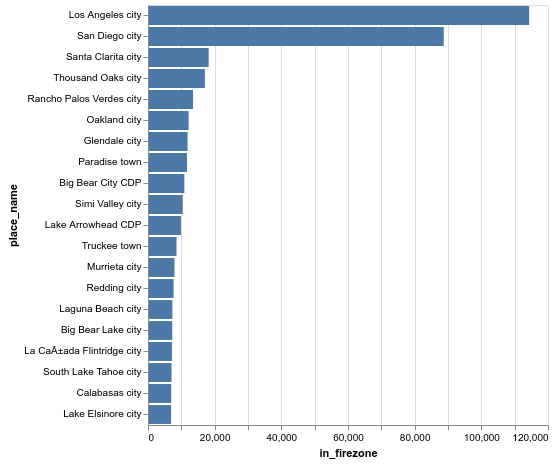

In [44]:
alt.Chart(top_places.reset_index()).mark_bar().encode(
    x="in_firezone:Q",
    y=alt.Y(
        "place_name:N",
        sort=alt.EncodingSortField(field="in_firezone", op="sum", order="descending")
    )
)

How many cities have more than 90% of the buildings in the "very severe" zones?

In [45]:
very_high_places = place_pivot[place_pivot.in_firezone_percent >= 90]

In [46]:
intcomma(len(very_high_places))

174


Are Paradise, Malibu and Topanga in this group?

In [47]:
very_high_places.reset_index()[
    very_high_places.reset_index().place_name.isin([
        'Paradise town',
        'Malibu city',
        'Topanga CDP'
    ])
]

in_firezone,place_name,not_in_firezone,in_firezone,total,in_firezone_percent
102,Malibu city,4.0,5963.0,5967.0,99.93
118,Paradise town,149.0,11703.0,11852.0,98.74
160,Topanga CDP,0.0,3574.0,3574.0,100.00


What Los Angeles neighborhoods have the most buildings "very severe" zones?

In [48]:
hood_pivot = crosstab_boolean(points, "neighborhood", "in_firezone")

In [49]:
top_hoods = hood_pivot.sort_values("in_firezone", ascending=False).head(20)

In [50]:
top_hoods

in_firezone,not_in_firezone,in_firezone,total,in_firezone_percent
neighborhood,,,,
Pacific Palisades,0.0,9303.0,9303.0,100.00
Hollywood Hills,226.0,6096.0,6322.0,96.43
Hollywood Hills West,65.0,5826.0,5891.0,98.90
Silver Lake,2794.0,5114.0,7908.0,64.67
Shadow Hills,915.0,5049.0,5964.0,84.66
Beverly Crest,6.0,4915.0,4921.0,99.88
Eagle Rock,5183.0,4836.0,10019.0,48.27
Brentwood,3583.0,4813.0,8396.0,57.32
Sherman Oaks,11855.0,4497.0,16352.0,27.50


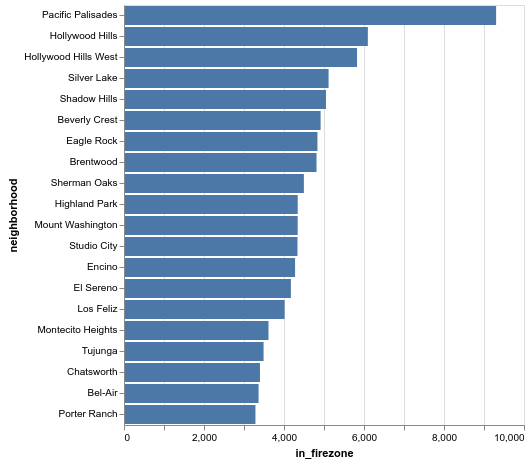

In [51]:
alt.Chart(top_hoods.reset_index()).mark_bar().encode(
    x="in_firezone:Q",
    y=alt.Y(
        "neighborhood:N",
        sort=alt.EncodingSortField(field="in_firezone", op="sum", order="descending")
    )
)

How many neighborhoods have 1,000 or more?

In [52]:
len(hood_pivot[hood_pivot.in_firezone >= 1000])

30

### Merge grids

Group our building points into grids that segment that state by running [merge-grids.ipynb](src/merge-grids.ipynb).

In [33]:
%%capture
%run src/merge-grids.ipynb

### Analyze grids

Calculate the number of at-risk buildings in each grid segment by running [analyze-grids.ipynb](src/analyze-grids.ipynb).

In [ ]:
%%capture
%run src/analyze-grids.ipynb